# Hyperparmeter Tuning of models

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

import pickle
%matplotlib inline
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")

### Importing the dataset

In [39]:
from os import path
X_train_final = np.load('X_train_final.npy')
X_test_final = np.load('X_test_final.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
X_train_final.shape

(150654, 383)

## SGD Regressor

In [21]:
# prepare a range of alpha values to test
alphas = np.array([0.01, 0.1, 1, 10, 100, 1e3, 1e4])

model = SGDRegressor(loss='squared_loss', penalty='l2', random_state=10)
grid = GridSearchCV(estimator=model, param_grid=dict(
    alpha=alphas), n_jobs=-1, scoring='neg_mean_squared_error',cv=3, return_train_score=True)

grid.fit(X_train_final, np.log(y_train))

print(grid)
# summarize the results of the grid search
print('Best best_score :',grid.best_score_)
print('Best estimator :', grid.best_estimator_.alpha)
with open('sgd_grid.pkl', 'wb') as f:
    pickle.dump(grid, f)

GridSearchCV(cv=3, estimator=SGDRegressor(random_state=10), n_jobs=-1,
             param_grid={'alpha': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])},
             return_train_score=True, scoring='neg_mean_squared_error')
Best best_score : -1.5935429309798177
Best estimator : 10.0


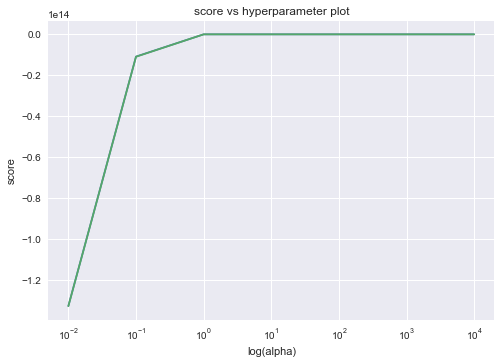

In [25]:
results = grid.cv_results_
alphas = results['param_alpha'].data
mean_train_score= results['mean_train_score']
mean_test_score = results['mean_test_score']

sns.lineplot(x=alphas,y=mean_train_score)
sns.lineplot(x=alphas,y=mean_test_score)
plt.title('score vs hyperparameter plot')
plt.xscale('log')
plt.xlabel('log(alpha)')
plt.ylabel('score')
plt.show()

## Random forest

**Finding optimal max_depth**

In [ ]:
rf_reg = RandomForestRegressor(criterion='mse',
                               
                               oob_score=True, n_jobs=-1, random_state=10,
                               )
params_cv = {
    'n_estimators': [50, 80, 100, 150, 200],
    "min_samples_split": [10, 50, 80, 100, 150],
    "min_samples_leaf": [10, 50, 80, 100, 150],
    "max_samples": [0.2, 0.3, 0.4, 0.5],
    'max_depth': [6, 8, 10, 12, 14]

}

grid = RandomizedSearchCV(rf_reg,
                          param_distributions=params_cv,
                          n_iter=20, cv=3,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1,
                          return_train_score=True,
                          random_state=10)

grid.fit(X_train_final, np.log(y_train))

print(grid)
# summarize the results of the grid search
print('Best best_score :', grid.best_score_)
print('Best estimator :', grid.best_estimator_)
with open('rf_reg_grid.pkl', 'wb') as f:
    pickle.dump(grid, f)

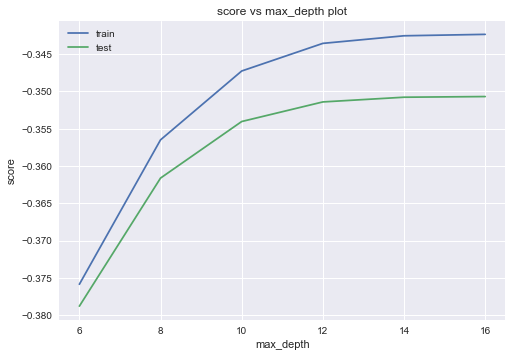

In [56]:
results = grid.cv_results_
max_depth = results['param_max_depth'].data
mean_train_score= results['mean_train_score']
mean_test_score = results['mean_test_score']

sns.lineplot(x=max_depth,y=mean_train_score,label='train')
sns.lineplot(x=max_depth,y=mean_test_score,label='test')
plt.title('score vs max_depth plot')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.show()

**Finding optimal min_samples_split**

In [7]:
rf_reg = RandomForestRegressor(n_estimators=50, criterion='mse',max_depth=16,
                               min_samples_leaf=100,n_jobs=-1, random_state=10,
                               max_samples=0.2)

min_samples_split = np.array([20, 40, 80, 120, 200, 250])

grid = GridSearchCV(estimator=rf_reg,
                    param_grid=dict(min_samples_split=min_samples_split),
                    n_jobs=-1, scoring='neg_mean_squared_error',
                    cv=3, return_train_score=True)

grid.fit(X_train_final, np.log(y_train))

print(grid)
# summarize the results of the grid search
print('Best best_score :', grid.best_score_)
print('Best estimator :', grid.best_estimator_.min_samples_split)
with open('rf_min_samples_split_grid.pkl', 'wb') as f:
    pickle.dump(grid, f)

GridSearchCV(cv=3,
             estimator=RandomForestRegressor(max_depth=16, max_samples=0.2,
                                             min_samples_leaf=100,
                                             n_estimators=50, n_jobs=-1,
                                             oob_score=True, random_state=10),
             n_jobs=-1,
             param_grid={'min_samples_split': array([ 20,  40,  80, 120, 200, 250])},
             return_train_score=True, scoring='neg_mean_squared_error')
Best best_score : -0.3506907401854107
Best estimator : 200


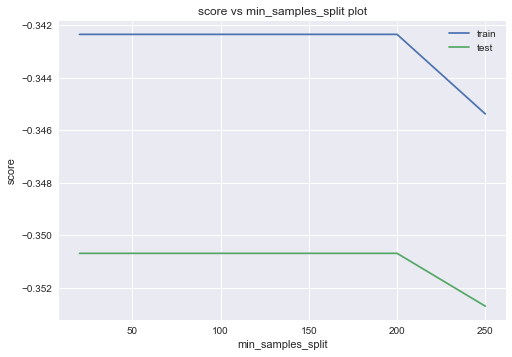

In [8]:
results = grid.cv_results_
min_samples_split = results['param_min_samples_split'].data
mean_train_score= results['mean_train_score']
mean_test_score = results['mean_test_score']

sns.lineplot(x=min_samples_split,y=mean_train_score,label='train')
sns.lineplot(x=min_samples_split,y=mean_test_score,label='test')
plt.title('score vs min_samples_split plot')
plt.xlabel('min_samples_split')
plt.ylabel('score')
plt.show()

**Finding optimal n_estimators**

In [10]:
rf_reg = RandomForestRegressor(criterion='mse', max_depth=16, min_samples_split=200,
                               min_samples_leaf=100, n_jobs=-1, random_state=10,
                               max_samples=0.2)

n_estimators = np.array([40, 60, 80, 100, 120, 150, 200])

grid = GridSearchCV(estimator=rf_reg,
                    param_grid=dict(n_estimators=n_estimators),
                    n_jobs=-1, scoring='neg_mean_squared_error',
                    cv=3, return_train_score=True)

grid.fit(X_train_final, np.log(y_train))

print(grid)
# summarize the results of the grid search
print('Best best_score :', grid.best_score_)
print('Best n_estimators :', grid.best_estimator_.n_estimators)
with open('rf_n_estimators_grid.pkl', 'wb') as f:
    pickle.dump(grid, f)

GridSearchCV(cv=3,
             estimator=RandomForestRegressor(max_depth=16, max_samples=0.2,
                                             min_samples_leaf=100,
                                             min_samples_split=200, n_jobs=-1,
                                             random_state=10),
             n_jobs=-1,
             param_grid={'n_estimators': array([ 40,  60,  80, 100, 120, 150, 200])},
             return_train_score=True, scoring='neg_mean_squared_error')
Best best_score : -0.3501762018004177
Best n_estimators : 200


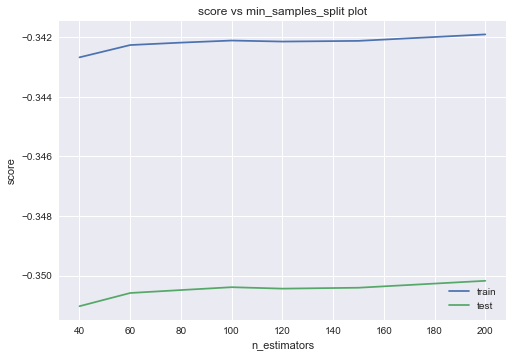

In [11]:
results = grid.cv_results_
n_estimators = results['param_n_estimators'].data
mean_train_score= results['mean_train_score']
mean_test_score = results['mean_test_score']

sns.lineplot(x=n_estimators,y=mean_train_score,label='train')
sns.lineplot(x=n_estimators,y=mean_test_score,label='test')
plt.title('score vs min_samples_split plot')
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show()

## Gradient boosted decision trees

In [7]:
estimator = XGBRegressor(objective='reg:squarederror',
                         n_estimators=100,
                         booster='gbtree',
                         learning_rate=0.1,
                         gamma=0.1,
                         random_state=10,
                         n_jobs=-1)
params_cv = {
    "max_depth": [4, 5, 6, 8, 10],
    "min_child_weight": [1, 3, 5, 7, 9],
    "gamma": [0, 0.1, 0.3, 0.5],
    "subsample": [0.5, 0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8]
}

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
randcv = RandomizedSearchCV(estimator, 
                                  param_distributions=params_cv,
                                  n_iter=30, cv=3,
                                  scoring='neg_mean_squared_error',
                                  n_jobs=-1, 
                                  return_train_score=True,
                                  random_state=10)
randcv.fit(X_train_final, np.log(y_train))
print(randcv)
print('Best params: ', randcv.best_params_)
with open('xgb_reg.pkl', 'wb') as f:
    pickle.dump(randcv, f)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster='gbtree',
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=0.1,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.1,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validate

In [36]:
cvresult = pd.DataFrame(randcv.cv_results_)
cvdf = cvresult[['params', 'mean_train_score', 'mean_test_score']]
for i in range(len(cvdf)):
    print('iteration :', i+1)
    print(cvdf.iloc[i].params)
    print('mean_train_score: ', cvdf.iloc[i].mean_train_score)
    print('mean_test_score: ', cvdf.iloc[i].mean_test_score)
    print()

iteration : 1
{'subsample': 0.7, 'min_child_weight': 9, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
mean_train_score:  -0.301510580684274
mean_test_score:  -0.3102837923083608

iteration : 2
{'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 6, 'gamma': 0, 'colsample_bytree': 0.8}
mean_train_score:  -0.27390871600764305
mean_test_score:  -0.30255088436662514

iteration : 3
{'subsample': 0.5, 'min_child_weight': 3, 'max_depth': 6, 'gamma': 0.1, 'colsample_bytree': 0.6}
mean_train_score:  -0.2775782398157746
mean_test_score:  -0.3047169247627239

iteration : 4
{'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 6, 'gamma': 0.1, 'colsample_bytree': 0.8}
mean_train_score:  -0.2722896909888158
mean_test_score:  -0.3025965602080171

iteration : 5
{'subsample': 0.5, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 0, 'colsample_bytree': 0.6}
mean_train_score:  -0.2908667713515417
mean_test_score:  -0.3068788827801281

iteration : 6
{'subsample': 0.7, 'min_child_weight': 5, 'm